In [57]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

import os, csv, time
os.chdir('D:/projects/video_regression/code/ml_pl')

import numpy as np
from sklearn.externals import joblib
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics.pairwise import chi2_kernel, rbf_kernel
from multichannel_svr.multichannel_svr import MultiChannelSVR, MultiChannelSVR2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#paths to mappings/features
dataset_root = 'D:/projects/THE_dataset' #directory where features/labels kept
mapping_path = os.path.join(dataset_root, 'ratings_by_filename_it35.csv')
train_path = os.path.join(dataset_root, 'train_set.pkl')
test_path = os.path.join(dataset_root, 'test_set.pkl')
c3d_path = os.path.join(dataset_root, 'C3D_features_wLoad.npz')

In [3]:
#load labels
def load_mapping(mapping_path):
    with open(mapping_path, 'rb') as f:
        import csv
        cr = csv.reader(f)
        mapping_list = []
        for row in cr:
            row[1] = float(row[1])
            mapping_list.append(row)
    return mapping_list            

In [4]:
#function for assigning labels to feature_dict
def assign_label(feature_dict, mapping):
    for ii,name in enumerate(feature_dict['Video_Name']):
        mapping_row = filter(lambda x: x[0] == name[0], mapping)[0]
        label = float(mapping_row[1])
        feature_dict['Label'][ii] = label        
    return feature_dict

In [5]:
#function - adding in c3d features
def incorporate_c3d(feature_dict, c3d_feats, c3d_names):
    num_instances = len(feature_dict['HOG']) #number of instances
    num_c3d_feats = c3d_feats.shape[1]
    c3d = np.empty((num_instances, num_c3d_feats))
    for ii, video_name in enumerate(feature_dict['Video_Name']):
        ind = np.where(c3d_names == video_name[0])[0][0]
        c3d[ii,:] = c3d_feats[ind,:]
    feature_dict['c3d'] = c3d
    return feature_dict

In [6]:
#function for turning feature_dict into multi-channel tuple
def prep_multichannel_data(feature_dict, return_labels=False, feature_list=['Trajectory', 'HOG', 'HOF', 'MBHx', 'MBHy']):
    multichannel_list = []
    for feature in feature_list:
        data = np.array(feature_dict[feature])
        #normalise
        if feature=='c3d':
            data_norm = normalize(data, axis=1, norm='l2')
        else:
            data_norm = normalize(data, axis=1, norm='l1')
        multichannel_list.append(data_norm)    
    if not return_labels:
        return tuple(multichannel_list)
    else:
        labels = feature_dict['Label']
        return tuple(multichannel_list), np.array(labels)

In [73]:
#save the results
def save_results(video_name_list, y_test, y_pred, filename='SVR_traj_c3d_combined_results.csv'):
    with open(filename, 'wb') as f:
        import csv
        cw = csv.writer(f)
        cw.writerow(['Video_Name', 'y_test', 'y_pred'])
        for ii, name in enumerate(video_name_list):
            row = [name, y_test[ii], y_pred[ii]]
            cw.writerow(row) 

In [125]:
#visualise
def plot_regression(y_test, y_pred, score=None, scatter_color='blue', title='Regression results'):
    
    #plot on axis
    fig, ax = plt.subplots(figsize=(15,12))
    ax.scatter(y_test, y_pred, alpha=.2, s=120, color=scatter_color)
    
    #perfect model line
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
            linestyle='-', color='k', linewidth=2, label='Perfect prediction')
    
    #line of best fit to the learned model
    par = np.polyfit(y_test, y_pred, 1, full=True)
    m = par[0][0]; c=par[0][1]
    model_line_x = [min(y_test), max(y_test)]
    model_line_y = [m*x + c for x in model_line_x]
    ax.plot(model_line_x, model_line_y, 
            linestyle='--', color=scatter_color, linewidth=2, label='Model prediction')
    
    #put in the R score
    if score:
        ax.text(model_line_x[1]+.2, model_line_y[1], r'$R={:.2f}$'.format(score), fontsize=18, color=scatter_color)
    
    #axis formatting
    ax.set_xlim([10,45])
    ax.set_ylim([10,45])
    ax.set_xlabel(r'Load (observed)', fontsize=16, labelpad=20)
    ax.set_ylabel(r'Load (model)', fontsize=16, labelpad=20)
    ax.set_title(title, fontsize=16)
    
    #misc
    ax.legend()
    ax.grid(True)
    
    return fig, ax

##Data preparation

In [9]:
#load the datasets
train_set = joblib.load(train_path)
test_set = joblib.load(test_path)
c3d_all = np.load(c3d_path)

In [10]:
mapping = load_mapping(mapping_path)

In [11]:
train_data = assign_label(train_set.feature_dict, mapping)
test_data = assign_label(test_set.feature_dict, mapping)
train_data_wc3d = incorporate_c3d(train_data, c3d_all['all_fvs'], c3d_all['all_filenames'])
test_data_wc3d = incorporate_c3d(test_data, c3d_all['all_fvs'], c3d_all['all_filenames'])

##Multichannel SVR with c3d features

In [131]:
feature_list=['Trajectory', 'HOG', 'HOF', 'MBHx', 'MBHy', 'c3d']
X_train, y_train = prep_multichannel_data(train_data_wc3d, return_labels=True, feature_list=feature_list)
X_test, y_test = prep_multichannel_data(test_data_wc3d, return_labels=True, feature_list=feature_list)

In [132]:
#define the kernel parameters for each channel
chi2_gammas=(.5,1,1,1,.5)
kernel_param_list = [ {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gamma}} for gamma in chi2_gammas]
kernel_param_list.append( {'kernel_func': rbf_kernel, 'param_dict': {'gamma': 2}} )
kernel_param_tuple = tuple(kernel_param_list)

In [133]:
t0= time.time()
mcsvr = MultiChannelSVR2(num_channels=6, model_param_dict={'C':5}, kernel_param_tuple=kernel_param_tuple)
mcsvr.fit(X_train, y_train)
t1 = time.time()-t0
print 'training time: {0}'.format(t1)

training time: 122.359999895


In [134]:
#predict
y_pred = mcsvr.predict(X_test)
score = r2_score(y_test, y_pred)
print 'R^2 score of {0} \nCorrelation of {1}'.format(score, np.sqrt(score))

R^2 score of 0.641326272675 
Correlation of 0.800828491423


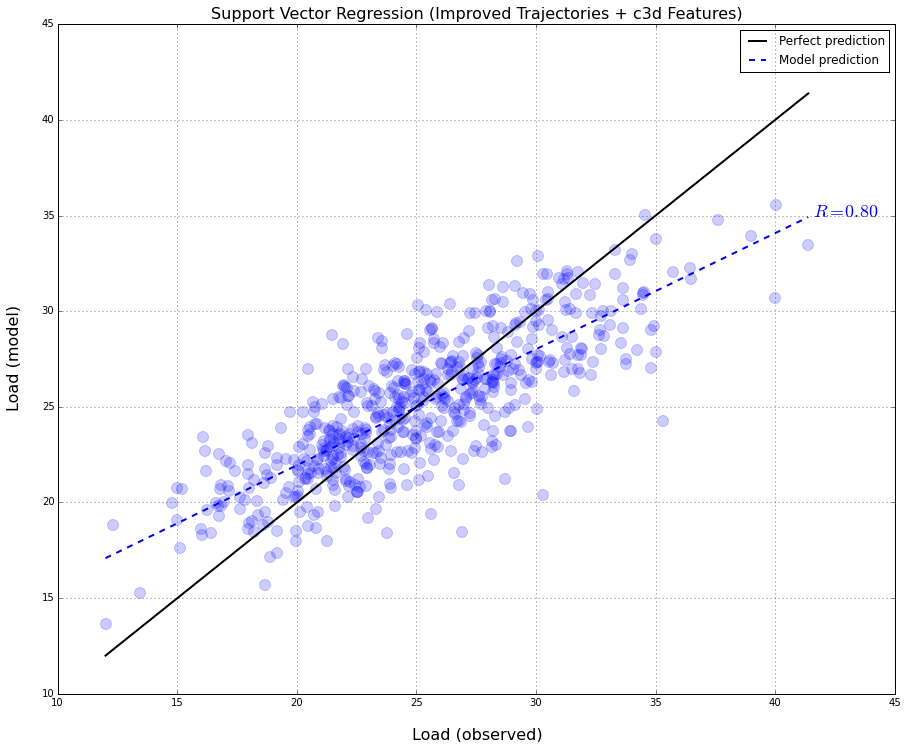

In [139]:
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), scatter_color='blue', title='Support Vector Regression (Improved Trajectories + c3d Features)')

In [76]:
video_name_list = map(lambda x: x[0], test_set.feature_dict['Video_Name'])
save_results(video_name_list=video_name_list, y_test=y_test, y_pred=y_pred)

##Multichannel SVR (improved trajectories + c3d) with weighted samples

In [180]:
#weight of training samples
scaler = MinMaxScaler(feature_range=(0,2))
sample_weight = (scaler.fit_transform(y_train))**20

t0 = time.time()
mcsvr_weighted = MultiChannelSVR2(num_channels=6, model_param_dict={}, kernel_param_tuple=kernel_param_tuple)
mcsvr_weighted.fit(X_train, y_train, sample_weight=sample_weight)
t1 = time.time()-t0
print 'training time: {0}'.format(t1)

training time: 124.552999973


In [181]:
#predict
y_pred_weighted = mcsvr_weighted.predict(X_test)
score = r2_score(y_test, y_pred)
print 'R^2 score of {0} \nCorrelation of {1}'.format(score, np.sqrt(score))

R^2 score of 0.641326272675 
Correlation of 0.800828491423


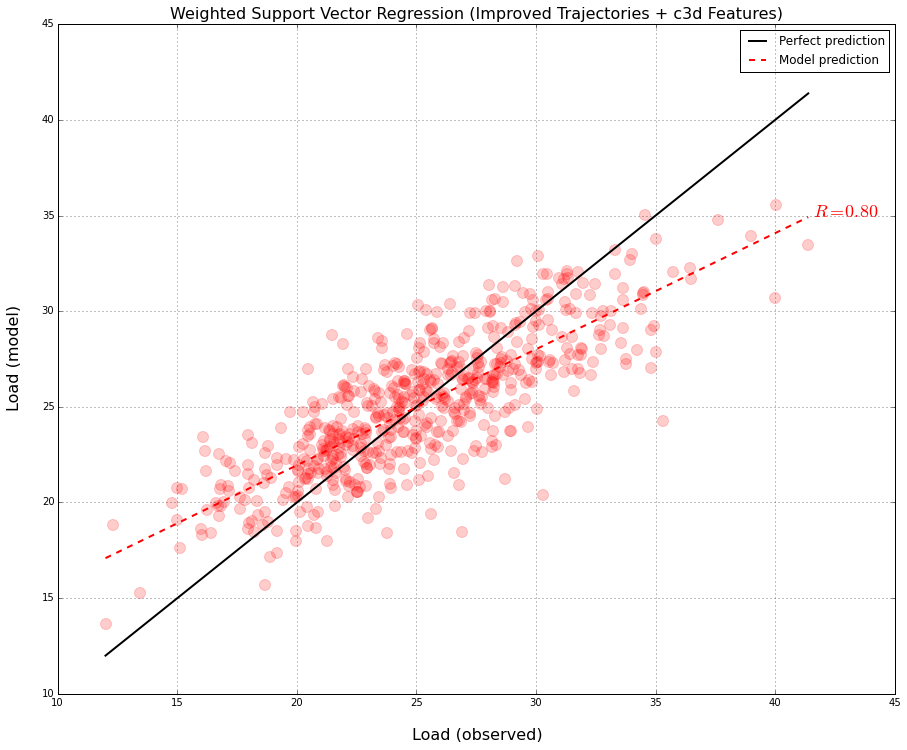

In [183]:
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), scatter_color='red', title='Weighted Support Vector Regression (Improved Trajectories + c3d Features)')

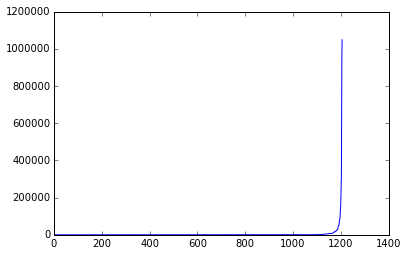

In [175]:
scaler = MinMaxScaler(feature_range=(0,2))
sample_weight = (scaler.fit_transform(y_train))**20
sorted(sample_weight)[600]
plt.plot(sorted(sample_weight))

##Multichannel SVR with improved trajectories only

In [102]:
feature_list=['Trajectory', 'HOG', 'HOF', 'MBHx', 'MBHy']
X_train, y_train = prep_multichannel_data(train_data, return_labels=True, feature_list=feature_list)
X_test, y_test = prep_multichannel_data(test_data, return_labels=True, feature_list=feature_list)

In [103]:
#define the kernel parameters for each channel
chi2_gammas=(.5,1,1,1,.5)
kernel_param_list = [ {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gamma}} for gamma in chi2_gammas]
kernel_param_tuple = tuple(kernel_param_list)

In [104]:
t0= time.time()
mcsvr = MultiChannelSVR2(num_channels=5, model_param_dict={'C':5}, kernel_param_tuple=kernel_param_tuple)
mcsvr.fit(X_train, y_train, sample_weight=None)
t1 = time.time()-t0
print 'training time: {0}'.format(t1)

training time: 122.525000095


In [105]:
#predict
y_pred = mcsvr.predict(X_test)
score = r2_score(y_test, y_pred)
print 'R^2 score of {0} \nCorrelation of {1}'.format(score, np.sqrt(score))

R^2 score of 0.60408159318 
Correlation of 0.77722686082


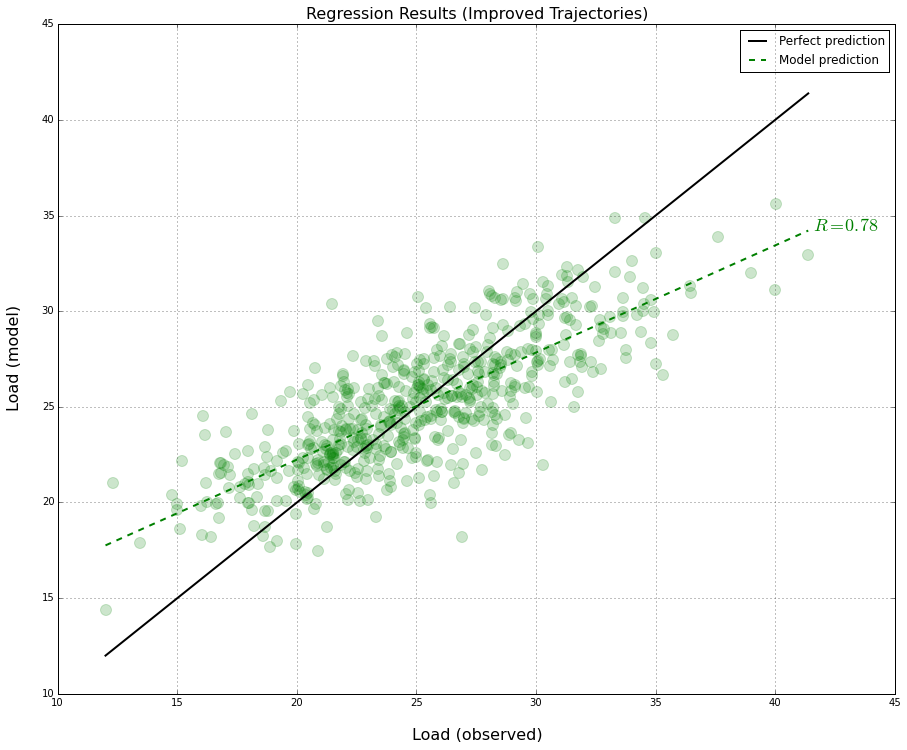

In [127]:
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), scatter_color='green', title='Regression Results (Improved Trajectories)')